**Imports**

In [1]:
import json
from pprint import pprint
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from pathlib import Path

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/tim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tim/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Constructing the basic dataset

In [8]:
data_folder = Path('../data/twint')
tweets_file = data_folder / 'data_new2.txt'

In [9]:
f = open(tweets_file, 'r')
lines = [l for l in f]
f.close()

In [10]:
tweets = [json.loads(l) for l in lines]
print(tweets[0])

{'id': 1134217832886149120, 'conversation_id': '1134217832886149120', 'created_at': 1559253578000, 'date': '2019-05-30', 'time': '23:59:38', 'timezone': '+0200', 'user_id': 803710812649033728, 'username': 'fuelvc', 'name': 'Fuel Venture Capital', 'place': '', 'tweet': '"The question prospective investors have to ask themselves about #Uber is not how much the stock has dipped since the #IPO, but do they think @Uber will be successful 10 years from now," says Managing Director of Rokk3r Fuel @LPFocused @CNBCClosingBell  https://cnb.cx/2YRrRFw\xa0', 'language': 'en', 'mentions': ['uber', 'cnbcclosingbell'], 'urls': ['https://cnb.cx/2YRrRFw'], 'photos': [], 'replies_count': 0, 'retweets_count': 0, 'likes_count': 11, 'hashtags': ['#uber', '#ipo'], 'cashtags': [], 'link': 'https://twitter.com/FuelVC/status/1134217832886149120', 'retweet': False, 'quote_url': '', 'video': 0, 'near': '', 'geo': '', 'source': '', 'user_rt_id': '', 'user_rt': '', 'retweet_id': '', 'reply_to': [{'user_id': '80371

In [11]:
print('Number of tweets:\t%s' % len(tweets))

Number of tweets:	51853


## Top 20 Hashtags

In [12]:
hashtags = [h for t in tweets for h in t['hashtags']]

In [13]:
from collections import Counter
hashtags_count = pd.DataFrame.from_dict(Counter(hashtags), orient='index', columns=['count']).sort_values(by='count', ascending=False)[:20]
hashtags_count

,count
#uber,37820
#lyft,14880
#uberlyftstrike,3739
#uberipo,3357
#taxi,2501
#ipo,2452
#rideshare,1623
#uk,1557
#tfl,1510
#uberstrike,1429


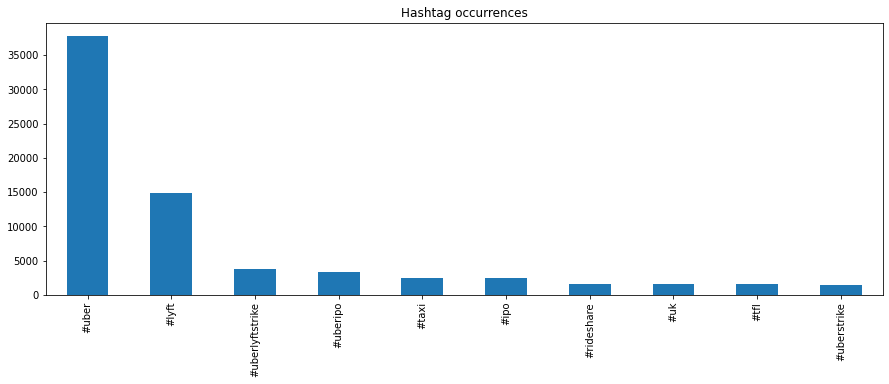

In [14]:
all_hashtags = []
for t in tweets:
    hashtags = t['hashtags']
    for h in hashtags:
        all_hashtags.append(h)
                                  
hashtags_counter = Counter(all_hashtags)
hashtag_count_df = pd.DataFrame.from_dict(hashtags_counter, orient='index', columns=['count']).sort_values(by=['count'], ascending=False).head(10)
hashtag_count_df.plot(kind='bar', legend=False, title='Hashtag occurrences', figsize=(15, 5))
plt.show()

## Tweet Time Distribution

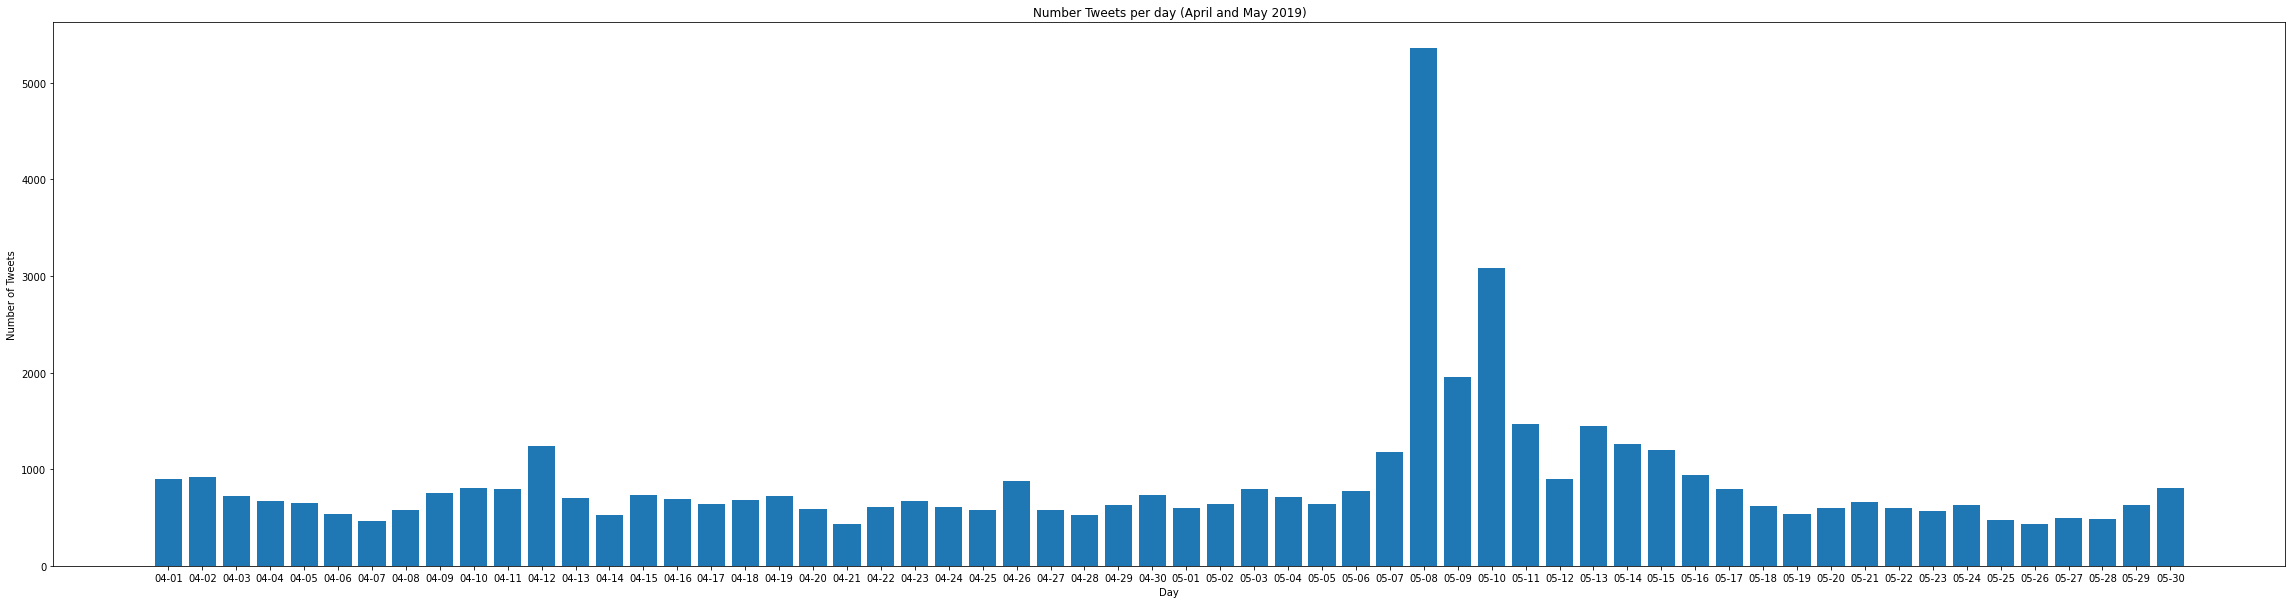

In [15]:
dates_to_n_tweets = {}

for t in tweets:
    date = t['date'].split('-')[1] + '-' + t['date'].split('-')[2]
    try:
        dates_to_n_tweets[date] = dates_to_n_tweets[date] + 1
    except:
        dates_to_n_tweets[date] = 0

sorted_dates = sorted(dates_to_n_tweets.items())
plt.figure(1, figsize=(40, 10))
plt.bar([e[0] for e in sorted_dates], [e[1] for e in sorted_dates])
plt.title('Number Tweets per day (April and May 2019)')
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.show()

# Text preparation

In [16]:
stop_words = stopwords.words('english')
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [17]:
def word_tokenize(tweet):
    return tokenizer.tokenize(tweet)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# https://stackoverflow.com/a/49146722/330558
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    #Remove numbers
    tweet = re.sub(r"[0-9]", '', tweet, flags=re.MULTILINE)
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove emojis
    tweet = remove_emoji(tweet)
    # Tokenize
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    # Stemming
    #shortened = [stemmer.stem(w) for w in filtered_words]
    # Lemmatizing
    shortened = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_words]
    # Remove non-alpha words
    filtered_stemmed = [w for w in shortened if w.isalpha()]
    # Filter out short lemmas
    final_tokens = [w for w in filtered_stemmed if len(w) > 2]
    
    return final_tokens

In [18]:
unique_usernames = {t['username'] for t in tweets}
users_to_documents = {u:[] for u in unique_usernames}

for tw in tweets:
    u = tw['username']
    t = preprocess_tweet_text(tw['tweet'])
    users_to_documents[u] = users_to_documents[u] + t

print(list(users_to_documents.items())[100])

('pelhamprog', ['uberlyftstrike', 'driver', 'demand', 'living', 'wage', 'world', 'wealthy', 'companiesfacts', 'tcfdotorg', 'today', 'sweatshop', 'wheel'])


## See document length distribution

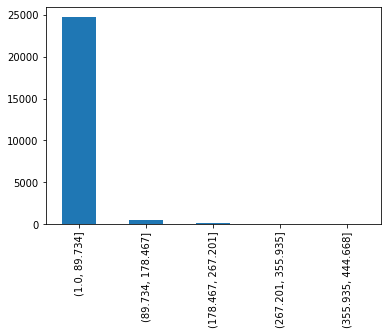

In [19]:
lengths = {u:len(doc) for (u, doc) in users_to_documents.items()}
min = np.min(list(lengths.values()))
max = np.max(list(lengths.values()))
bins = np.linspace(start=min, stop=max, num=200, endpoint=True)

labels = list(range(199))

lengths_df = pd.DataFrame({'Doc': list(lengths.keys()), 'Length': list(lengths.values())})

s = pd.cut(lengths_df['Length'], bins=bins).value_counts()

s.head().plot(kind='bar')

## Filter out any users that now have less than 100 tokens

In [87]:
print(len(users_to_documents.values()))
users_to_documents_doc_length_filtered = {u:doc for (u, doc) in users_to_documents.items() if len(doc) >= 120}
print(len(users_to_documents_doc_length_filtered.values()))

25558
557


## Filter out any users with a very low lexical diversity

In [88]:
def lexical_diversity_percentage(tokens):
    return len(set(tokens)) / len(tokens) * 100

### Lexical diversity histogram

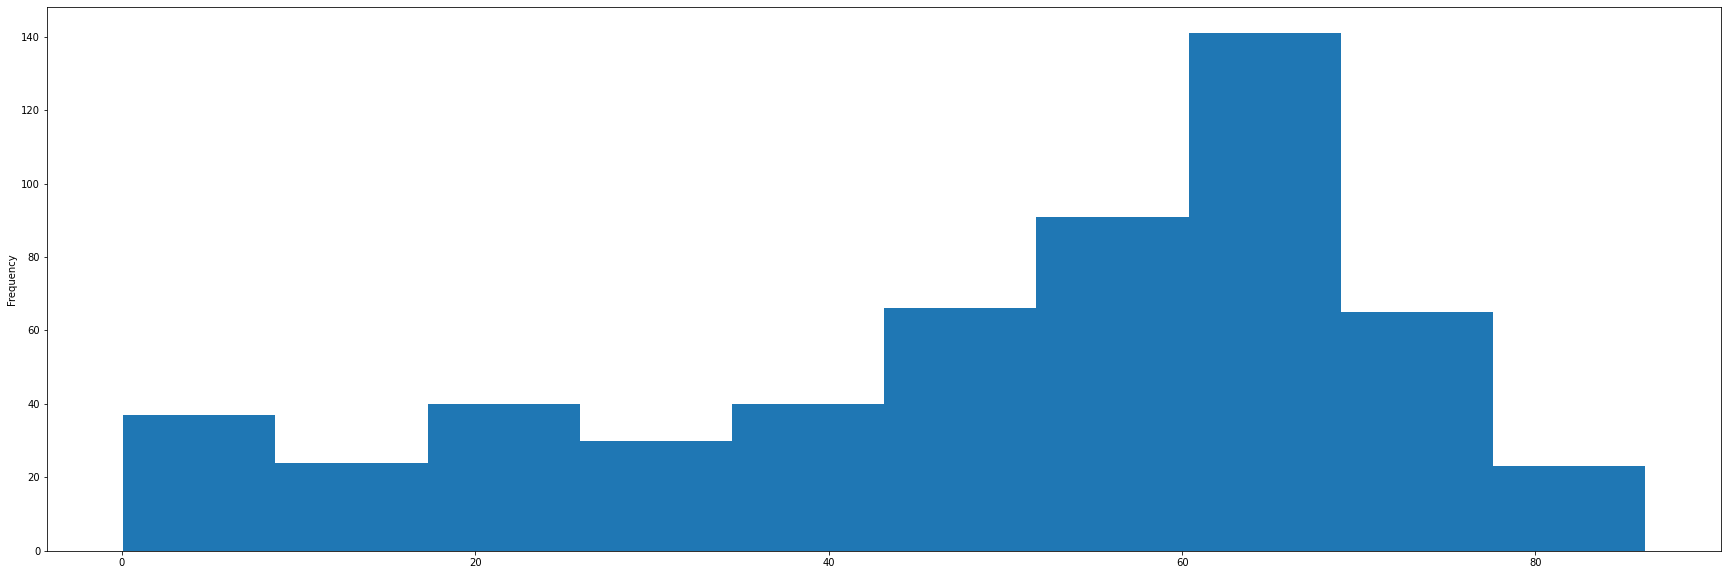

In [89]:
lexical_diversities = {u:lexical_diversity_percentage(doc) for (u, doc) in users_to_documents_doc_length_filtered.items()}
lexical_div_df = pd.DataFrame.from_dict(lexical_diversities, orient='index', columns=['diversity'])
lexical_div_df.groupby('diversity')
plt.figure(1, figsize=(30, 10))
lexical_div_df['diversity'].plot(kind='hist')

In [90]:
print(len(users_to_documents_doc_length_filtered))
users_to_documents_filtered = {u:doc for (u, doc) in users_to_documents_doc_length_filtered.items() if lexical_diversity_percentage(doc) >= 40}
len(users_to_documents_filtered)

557


399

# Constructing the Term/Document Matrix

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [92]:
docs = users_to_documents_filtered.values()

In [101]:
def do_nothing(tokens):
    return tokens

vectorizer = TfidfVectorizer(lowercase=False, tokenizer=do_nothing, min_df=0.3, max_df=0.7)

X = vectorizer.fit_transform(docs)

In [102]:
tf_idf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [103]:
tf_idf_df

,app,billion,business,car,come,company,day,drive,get,investor,...,see,share,stock,strike,take,time,today,well,work,year
0,0.000000,0.192690,0.000000,0.000000,0.000000,0.050546,0.115076,0.000000,0.048301,0.067072,...,0.000000,0.056817,0.061626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.335664,0.000000,0.000000,0.000000,0.187156,0.142228,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.318548,0.175537,0.000000,0.000000,0.193223,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.396986,0.000000,0.338035,0.000000,0.141882,0.000000,...,0.190691,0.166899,0.181027,0.198493,0.000000,0.175111,0.000000,0.000000,0.192754,0.000000
3,0.000000,0.000000,0.000000,0.317420,0.000000,0.422253,0.000000,0.000000,0.000000,0.560307,...,0.000000,0.000000,0.000000,0.000000,0.150617,0.000000,0.000000,0.000000,0.000000,0.172186
4,0.118257,0.000000,0.000000,0.101976,0.000000,0.090437,0.102946,0.000000,0.000000,0.000000,...,0.000000,0.101656,0.000000,0.846296,0.000000,0.000000,0.000000,0.233126,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.000000,0.000000,0.147574,0.000000,0.000000,0.233088,0.000000,0.000000,0.111366,0.154648,...,0.000000,0.000000,0.000000,0.311601,0.124713,0.137447,0.151844,0.150212,0.151296,0.000000
395,0.000000,0.000000,0.293470,0.130667,0.000000,0.579406,0.131910,0.145712,0.110732,0.153768,...,0.297652,0.130257,0.000000,0.000000,0.000000,0.136666,0.000000,0.000000,0.150435,0.000000
396,0.000000,0.000000,0.000000,0.000000,0.000000,0.308083,0.000000,0.387392,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.329679,0.363341,0.000000,0.000000,0.000000,0.000000
397,0.000000,0.093927,0.000000,0.000000,0.098814,0.000000,0.000000,0.000000,0.070632,0.196166,...,0.000000,0.581604,0.090119,0.000000,0.000000,0.087174,0.000000,0.095270,0.095957,0.000000


## Performing a PCA

In [104]:
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.normalize(tf_idf_df), columns=tf_idf_df.columns)
data_scaled

,app,billion,business,car,come,company,day,drive,get,investor,...,see,share,stock,strike,take,time,today,well,work,year
0,0.000000,0.192690,0.000000,0.000000,0.000000,0.050546,0.115076,0.000000,0.048301,0.067072,...,0.000000,0.056817,0.061626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.335664,0.000000,0.000000,0.000000,0.187156,0.142228,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.318548,0.175537,0.000000,0.000000,0.193223,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.396986,0.000000,0.338035,0.000000,0.141882,0.000000,...,0.190691,0.166899,0.181027,0.198493,0.000000,0.175111,0.000000,0.000000,0.192754,0.000000
3,0.000000,0.000000,0.000000,0.317420,0.000000,0.422253,0.000000,0.000000,0.000000,0.560307,...,0.000000,0.000000,0.000000,0.000000,0.150617,0.000000,0.000000,0.000000,0.000000,0.172186
4,0.118257,0.000000,0.000000,0.101976,0.000000,0.090437,0.102946,0.000000,0.000000,0.000000,...,0.000000,0.101656,0.000000,0.846296,0.000000,0.000000,0.000000,0.233126,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.000000,0.000000,0.147574,0.000000,0.000000,0.233088,0.000000,0.000000,0.111366,0.154648,...,0.000000,0.000000,0.000000,0.311601,0.124713,0.137447,0.151844,0.150212,0.151296,0.000000
395,0.000000,0.000000,0.293470,0.130667,0.000000,0.579406,0.131910,0.145712,0.110732,0.153768,...,0.297652,0.130257,0.000000,0.000000,0.000000,0.136666,0.000000,0.000000,0.150435,0.000000
396,0.000000,0.000000,0.000000,0.000000,0.000000,0.308083,0.000000,0.387392,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.329679,0.363341,0.000000,0.000000,0.000000,0.000000
397,0.000000,0.093927,0.000000,0.000000,0.098814,0.000000,0.000000,0.000000,0.070632,0.196166,...,0.000000,0.581604,0.090119,0.000000,0.000000,0.087174,0.000000,0.095270,0.095957,0.000000


## Perform the PCA

In [105]:
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(data_scaled)

In [106]:
len(X_reduced[:, 0])

399

## Analyze the percentage of explained variance per principal component

In [107]:
pd.DataFrame(pca.explained_variance_ratio_)

,0
0,0.159016
1,0.054808
2,0.052720
3,0.049344
4,0.047461
5,0.038554
6,0.035493
7,0.033631
8,0.031817
9,0.030775


In [108]:
explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(int(explained_variance * 100)))
print()

Explained variance of the PCA step: 53%



Text(0.5, 1.0, '2D Plot')

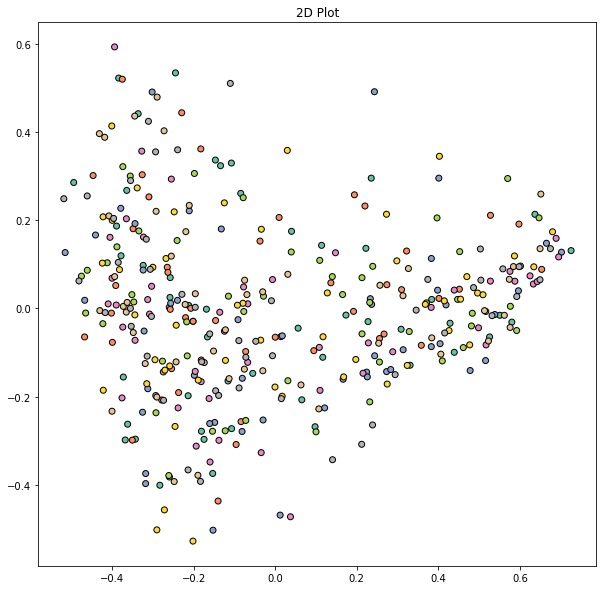

In [109]:
y = range(0, len(X_reduced))
plt.figure(1, figsize=(10, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.Set2, edgecolor='k')
plt.title('2D Plot')

## 3D Plot

Text(0.5, 0.92, 'PCA 3D Plot')

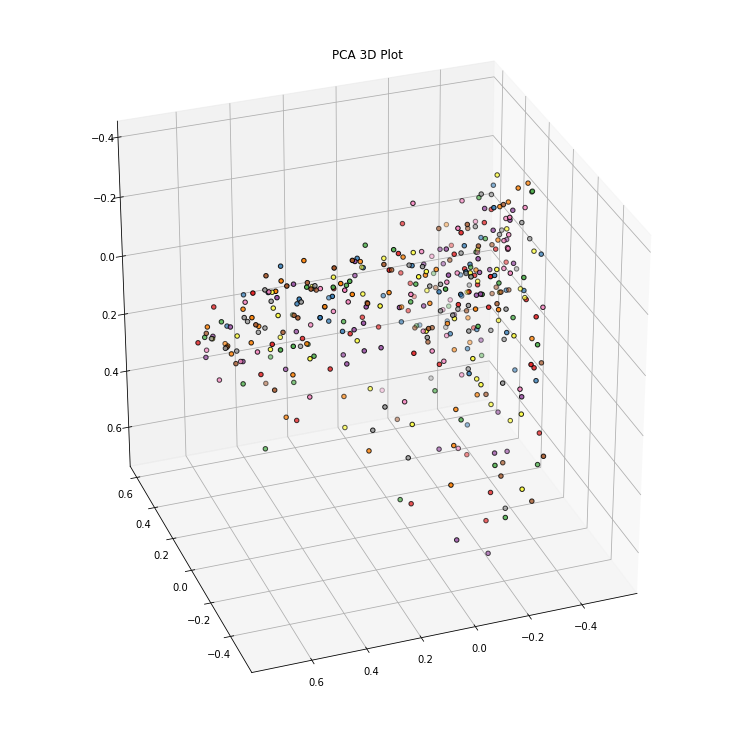

In [110]:
fig = plt.figure(1, figsize=(10, 10))
ax = Axes3D(fig, elev=-150, azim=110)
y = range(0, len(X_reduced))
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k')
ax.set_title("PCA 3D Plot")

## See the documents/users with highest MSE

In [85]:
inverse_transform_data = pca.inverse_transform(X_reduced)
MSE_score = ((data_scaled-inverse_transform_data)**2).sum(axis=1)

In [ ]:
MSE_max_scores = list(MSE_score.nlargest(10).index)

In [ ]:
docs_with_highest_mse_df = users_to_documents_df.iloc[MSE_max_scores]
docs_with_highest_mse_df

### See the length of the documents/users with highest MSE

In [ ]:
usernames_with_highest_mse = list(docs_with_highest_mse_df.index)
lengths_of_docs_with_highest_mse_df = pd.DataFrame.from_dict({u:len(users_to_documents[u]) for u in usernames_with_highest_mse}, orient='index', columns=['count']).sort_values(by='count', ascending=False)
lengths_of_docs_with_highest_mse_df

## See the documents/users with the lowest MSE

In [ ]:
MSE_low_scores = list(MSE_score.nsmallest(10).index)

In [ ]:
docs_with_lowest_mse_df = users_to_documents_df.iloc[MSE_low_scores]
docs_with_lowest_mse_df

### See the length of the documents/users with lowest MSE

In [ ]:
usernames_with_lowest_mse = list(docs_with_lowest_mse_df.index)
lengths_of_docs_with_lowest_mse_df = pd.DataFrame.from_dict({u:len(users_to_documents[u]) for u in usernames_with_lowest_mse}, orient='index', columns=['count']).sort_values(by='count', ascending=False)
lengths_of_docs_with_lowest_mse_df

In [111]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important_feature_indexes_per_pc = {}

initial_feature_names = data_scaled.columns

dfs = []

for pc in range(n_pcs):
    components_enumerated = list(enumerate(pca.components_[pc]))
    components_sorted = sorted(components_enumerated, key=lambda x:np.abs(x[1]), reverse=True)
    features_imps = {initial_feature_names[i]:imp for (i, imp) in components_sorted}
    features_imps_df = pd.DataFrame.from_dict(features_imps, orient='index', columns = ['importance'] )[:20]
    dfs.append(features_imps_df)
    
i = 1
for df in dfs:
    print('PCA %d' % i)
    print(df)
    print('')
    i += 1

PCA 1
          importance
ipo         0.757220
stock       0.230450
ride       -0.206139
get        -0.191786
drive      -0.171902
billion     0.166560
market      0.156384
price       0.143225
car        -0.137782
share       0.134924
public      0.128483
know       -0.124259
investor    0.121448
app        -0.115480
take       -0.113220
like       -0.101412
work       -0.100573
make       -0.095890
need       -0.088855
well       -0.086732

PCA 2
         importance
car        0.490402
ride       0.465091
strike    -0.414269
pay       -0.224961
today     -0.222272
work      -0.197869
day       -0.192502
app        0.188993
ipo        0.167015
may       -0.158202
company   -0.139509
stock     -0.111628
see       -0.096101
money     -0.093911
billion    0.091668
make      -0.088485
get        0.083105
well      -0.079965
take      -0.074477
like      -0.061361

PCA 3
          importance
strike      0.522983
app         0.363084
get        -0.348005
stock      -0.235656
know       -0.

# Clustering

In [112]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import Normalizer

In [117]:
normalizer = Normalizer(copy=False)
X_reduced_normalized = normalizer.fit_transform(X_reduced)
km = KMeans(n_clusters=2)
distances = km.fit_transform(X_reduced_normalized)

## Plotting the clusters

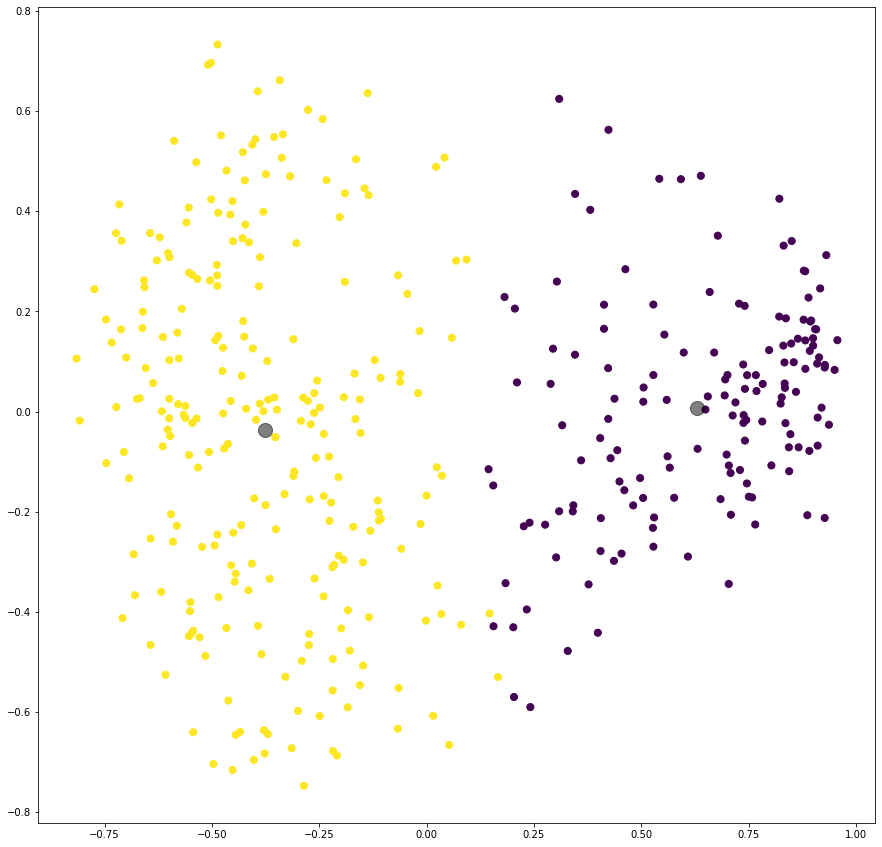

In [118]:
y_kmeans = km.labels_
plt.figure(figsize=(15, 15))
plt.scatter(X_reduced_normalized[:, 0], X_reduced_normalized[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [120]:
original_space_centroids = pca.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Cluster 0: ipo
 stock
 billion
 share
 market
 price
 public
 company
 investor
 year
Cluster 1: get
 car
 ride
 drive
 take
 make
 like
 app
 know
 pay


## Get the users per cluster

In [116]:
cluster_df = pd.DataFrame()
cluster_df['user'] = users_to_documents_df.index
cluster_df['cluster'] = km.labels_
cluster_df['distance_to_0'] = distances[:, 0]
cluster_df['distance_to_1'] = distances[:, 1]
cluster_df['distance_to_2'] = distances[:, 2]

NameError: name 'users_to_documents_df' is not defined

In [ ]:
# Cluster 0
users_cluster0 = cluster_df.loc[cluster_df['cluster'] == 0]
# Cluster 1
users_cluster1 = cluster_df.loc[cluster_df['cluster'] == 1]
# Cluster 2
users_cluster2 = cluster_df.loc[cluster_df['cluster'] == 2]

## Get the tweets per cluster

In [ ]:
tweets_cluster0 = [t for t in tweets if t['username'] in list(users_cluster0['user'])]    
tweets_cluster1 = [t for t in tweets if t['username'] in list(users_cluster1['user'])]
tweets_cluster2 = [t for t in tweets if t['username'] in list(users_cluster2['user'])]
texts_cluster0 = [t['tweet'] for t in tweets_cluster0]
texts_cluster1 = [t['tweet'] for t in tweets_cluster1]
texts_cluster2 = [t['tweet'] for t in tweets_cluster2]
print(texts_cluster0)